# Deep Reinforcement Learning for Navigation

---

Let's train an agent to navigate a large square world from the Unity ML-Agents Banana Collectors environment. Delicious yellow bananas reward the agent with one point while rotten blue bananas deduct one point. The agent's goal is to navigate toward yellow bananas and avoid blue bananas. We'll use Q-learning, deep neural networks with dueling architecture, and prioritized experience replay. 

Watch a video of the trained agent here: [https://youtu.be/8ec-FtBbxic](https://youtu.be/8ec-FtBbxic)

![Banana Collectors Environment](assets/banana_world.png)

## The Environment

---

The Banana Collectors environment is a large flat square world enclosed by walls. Yellow and blue bananas are scattered throughout the environment. Four discrete actions are available to the agent: move forward, move backward, turn left, and turn right. The agent senses the environmental state through ray-based perception of the objects in the forward direction and through velocity. These combine for a state space with 37 dimensions. Navigating to a yellow banana provides a reward of +1, while a blue banana provides a negative reward of -1. Each episode allows the agent 300 steps before ending. The criteria for solving the task is averaging a score of 13 points across 100 episodes. 

## Methods

---

### DQN (Deep Q-Network)

In 2015, researchers at Google DeepMind [1] developed a learning algorithm called DQN (deep Q-network) to train an agent capable of playing a wide range of Atari 2600 games at a level comparable to a professional human player. DQN combines reinforcement learning and deep learning by extending the classic Q-learning algorithm (Figure 1) with a deep neural network for approximating the Q-function $Q(s,a)$. 

$Q(s,a)$ enables an agent to estimate the value of taking action $a$ in state $s$. When the agent experiences a new state $s'$, it can generate a new target to update the Q-function based on the observed reward $r$ and an estimated future return. The future return is estimated by bootstrapping the current Q-function estimate, with the new state $s'$ as input, and assuming a greedy policy where the action with the maximum value is selected. Future returns are also discounted by the rate $\gamma$. Concretely, this Q-learning target is $r + \gamma \max_a Q(s',a)$. As in Figure 1, the algorithm updates the Q-function with a step size $\alpha$ based on the temporal-difference (TD) error between the new target and current estimate $Q(s,a)$.

![Q-Learning Algorithm](assets/qlearning_algorithm.png)
**Figure 1**: Q-learning algorithm in Sutton and Barto [2]

DQN uses a neural network function approximator to learn a Q-function $Q(s,a;\theta)$ parameterized by weights $\theta$, making the Q-learning target at time $t$:

$$
Y_t^{DQN} = r_{t+1} + \gamma \max_a Q(s_{t+1},a,\theta_t)
$$

The network parameters are updated based on the TD-error and gradient:

$$
\theta_{t+1} = \theta_t + \alpha \big(Y_t^{DQN} - Q(s_t,a_t;\theta_t)\big) \nabla_{\theta_t} Q(s_t,a_t;\theta_t)
$$

DQN employs an important feature of using two Q-networks to help stabilize learning. While the primary network with weights $\theta$ determines the policy and updates at every step, a second Q-network with parameters $\theta^-$ determines the Q-target. Updated only periodically with $\theta_t^-=\theta_t$, the DQN target becomes:

$$
Y_t^{DQN} = r_{t+1} + \gamma \max_a Q(s_{t+1},a,\theta_t^-)
$$

This periodically fixed target helps stabilize learning compared to using the primary network that is changing every time step.

A second important feature of DQN is experience replay, where learning occurs not based directly on the current state but from sampling a batch of previous experiences stored in the memory of a large replay buffer. The sampled batch of previous experiences helps decouple the agent from the influence of sequential transitions experienced online. The agent can then draw upon past experiences during learning.

### Double DQN

The Q-learning algorithm is biased toward overestimation [3] due to the max operation in the greedy policy. For example, a max operation over several actions with zero mean function approximator noise can produce an output with positive mean. Researchers addressed the overestimation bias with the Double DQN algorithm [4] by using separate networks for evaluating and selecting actions. One Q-network with $\theta_t$ evaluates actions to find the argmax action while another network with $\theta_t'$ selects the actual value using the argmax action from the first. The decoupling of evaluation and selection helps prevent action values from unduly influencing the target calculation. Double DQN fits nicely with DQN since the fixed Q-target technique already maintains two networks. The target for Double DQN is:

$$
Y_t^{DoubleDQN} = r_{t+1} + \gamma Q\big(s_{t+1},argmax_a Q(s_{t+1}, a; \theta_t);\theta_t'\big)
$$

### Prioritized Experience Replay

Researchers at DeepMind [5] improved the experience replay technique by sampling more intelligently from the replay buffer. Rather than treating experiences equally by sampling uniformly, the improvement assigns a priority to each experience to guide sampling. The TD error between the current and new estimate is one option for measuring priority. A large TD error indicates a correspondingly large potential for learning due to the gap between current and new knowledge. Moreover, we don't want an experience to get eliminated from the possibility of being sampled, so we make sure priorities are non-zero by adding a small positive number $\epsilon$. We can define the priority $p$ of experience $i$ as the absolute value of the TD-error $\delta$ plus a small number $\epsilon=0.001$:

$$
p_i = |\delta_i| + \epsilon
$$

The probability $P(i)$ of an experience $i$ being sampled is its priority divided by the sum of all $N$ priorities in the replay buffer:

$$
P(i) = \frac{p_i^\alpha}{\sum_N p_N^\alpha}
$$

The exponent $\alpha$ is a hyperparameter between 0 and 1. When $\alpha = 0$, we have completely uniform sampling since each experience has an equal probability $P(i)=\frac{1}{N}$ of being sampled. When $\alpha = 1$, sampling is purely based on priority. Fractional values allow us to modulate the impact of prioritized sampling to introduce some exploration of experiences beyond the ones with the highest priorities. Here, we adopt the value $\alpha = 0.6$ used in the paper [5].

Implementing prioritized replay requires efficiently assigning priorities across a large set of experiences in the replay buffer and sampling based on those priorities. The paper [5] discusses two approaches: a rank-based variant using a binary heap priority queue and a proportional variant using a sum tree data structure. 

This project uses the proportional variant with a sum tree, which is a binary tree where parent nodes sum the child nodes. Figure 2 shows an example of a sum tree from [Jaromir's blog post](https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/) [6], which provides a good detailed explanation. Essentially, the sum tree allows us to organize experiences and their priorities in the leaf nodes while efficiently summing the priorities at the root node. The sum of priorities is required for computing sampling probabilities $P(i)$ for each experience.

![Sum Tree Example](assets/sum_tree_example.jpeg)
**Figure 2**: Example of a sum tree from [Jaromir's blog post](https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/) [6]. Parent nodes sum the value of child nodes. The root node at the top is the sum of the leaf nodes, which are the child nodes in the bottom row.

In regular DQN, we estimate targets, compute losses, and update weights stochastically using batches of experiences randomly sampled from the replay buffer. Prioritized replay introduces bias since the updates are no longer based on sampling from a normal distribution. Experiences with high priority are sampled more frequently and thus influence the weight updates unduly. To correct the bias and counter the influence of the frequently sampled high priority experiences, importance-sampling weights $w$ are used:

$$
w(i) = \bigg(\frac{1}{N} \cdot \frac{1}{P(i)}\bigg)^\beta
$$

The weights are implemented in the Q-learning update by scaling the TD-error. The exponent $\beta$ controls the strength of the weights. When $\beta=0$, the weights become $w(i)=1$ and have no impact on the Q-learning update, while at $\beta=1$ they fully compensate for the bias. Because the bias becomes important toward the latter half of training when the action values are converging, $\beta$ is typically linearly ramped up across training. In this project, I adopt the same values used in the paper [5] by starting with $\beta=0.4$ and linearly annealing to a value of $\beta=1$ across training. 

### Dueling Network Architecture

The same year, researchers [7] further improved DQN with a modification to the neural network architecture using the concept of advantage values, defined as the difference between action values and the state value. For a policy $\pi$, advantage is:

$$
A^\pi(s,a) = Q^\pi(s,a) - V^\pi(s,a)
$$

While an action value measures the absolute value of taking an action in a given state, advantage measures the value of an action relative to the other available actions in that state. Prior to the network's Q-function output, the dueling architecture adds a split of the upstream network into a state value stream and an advantage value stream (Figure 3). The two streams are conveniently combined into the usual action value output using the definition of advantage. 

![Dueling Architecture](assets/dueling_architecture.png)
**Figure 3**: Dueling architecture (bottom) modifies the standard architecture (top) by splitting the network into two streams prior to recombining into an aggregation module to output the usual action value Q-function. One stream represents the state value function while the second stream represents the advantage function. [7]

Merely splitting the streams does not guarantee one will learn the state value and the other will learn the advantage value. For example, they could learn arbitrary values that combine to output Q. We need to provide closure so that the streams will represent state and advantage values. One way to do this is recognizing the action $a^*$ with the highest action value $Q(s,a^*)$ will also have the highest advantage value $A(s,a^*)$. We can include an extra term to force the advantage value of action $a^*$ to zero:

$$
Q(s,a') = V(s,a') - \Big(A(s,a') - \max_{a'\epsilon| \mathcal{A}|}A(s,a') \Big)
$$

The extra term subtracting the max advantage value ensures:

$$
Q(s,a^*) = V(s,a^*)
$$

This makes one stream represent the state value. By defining the network weights in the advantage stream as $\alpha$, in the value stream as $\beta$, and in the upstream shared network as $\theta$, we can specifically define the aggregating module as:

$$
Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) 
+ \Big(A(s,a;\theta,\alpha) - \max_{a'\epsilon| \mathcal{A}|}A(s,a';\theta,\alpha) \Big)
$$

Alternatively, for improved stability, we can swap the extra term with the max operation for a mean:

$$
Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) 
+ \bigg(A(s,a;\theta,\alpha) - \frac{1}{|\mathcal{A}|}\sum_{a'}A(s,a';\theta,\alpha) \bigg)
$$

Researchers at Deepmind found the dueling architecture learns state values more efficiently, since each step updates the state value rather than only one action value. The advantage function helps particularly when actions have similar values. The magntitude of the actions values can be much larger than the relative difference  between actions, which is what advantage measures.

A major benefit of dueling architecture is compatibility with many reinforcement learning algorithms. Since the implementation occurs all in the neural network rather than in the learning algorithm, it complements Double DQN and Prioritized Experience Replay.

## Implementation: Training the agent

---

Let's implement double DQN with dueling architecture and prioritized experience replay to training an agent to navigate the Banana Collectors environment. The file `dqn_agent.py` contains code to instantiate an DQN agent with an experience replay buffer. Flags in the agent attributes can enable double DQN, dueling architecture, and prioritized replay. The file `model.py` contains classes for a standard deep Q-network or one with dueling architecture. The standard network uses two hidden layers with 128 and 64 units, arrived at based on a rough search. Dropout was not used to prevent overfitting since the agent constantly receives more data while acting in the environment. Additionally, a `SumTree.py` file contains a reference implementation [7] of a sum tree data structure, which is used in prioritized replay.

To train the agent, we first load the Unity environment and inspect the action and state space. Second, we create a function to manage agent training across episodes until it can solve the environment. Third, we create an agent configured to our specifications and call the training function. 

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import torch
from collections import deque
from unityagents import UnityEnvironment
from dqn_agent import Agent
import time

# Start environment
env = UnityEnvironment(file_name="Banana.app", seed=10)

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Examine state and action spaces
env_info = env.reset(train_mode=True)[brain_name]
print('Number of agents:', len(env_info.agents))
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.19246322 0.
 1.         0.         0.         0.39209977 0.         0.
 0.         1.         0.         0.         1.         0.
 0.         0.19775437 0.         0.         1.         0.
 0.86202884 0.         1.         0.         0.         0.25187665
 0.         0.         0.         1.         0.         0.
 0.        ]
States have length: 37


In [2]:
def train_dqn(n_episodes=500, max_t=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.98,
              keep_training=False):
    """Train DQN Agent
    
    # Parameters 
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    solved = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
                
        if agent.prioritized:
            print('\rEpisode {}\tAverage Score: {:.2f}\teps: {:.4f}\tBeta: {:.4f}'
                  .format(i_episode, np.mean(scores_window), eps, agent.replay.beta), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}\teps: {:.4f}\tBeta: {:.4f}'
                      .format(i_episode, np.mean(scores_window), eps, agent.replay.beta))
        if not agent.prioritized: 
            print('\rEpisode {}\tAverage Score: {:.2f}\teps: {:.4f}'
                  .format(i_episode, np.mean(scores_window), eps), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}\teps: {:.4f}'
                      .format(i_episode, np.mean(scores_window), eps))
        if (np.mean(scores_window)>=13) and not solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnet_local.state_dict(), 'checkpoint.pth')
            solved = True
            if not keep_training: # keep training beyond "solved" criteria
                break
    
    # Save final weights
    torch.save(agent.qnet_local.state_dict(), 'weights_final.pth')

    return scores

In [3]:
# Create agent: Double DQN PER + Dueling
agent = Agent(state_size=37, action_size=4, seed=0, soft=True, 
              doubleDQN=True, duel=True, prioritized=True,
              alpha=0.6, beta_start=0.4, beta_end=1, beta_episodes=200,
              hidden_layers=[128,64], learn_rate=5e-4/2)

# Run training simulation
t0 = time.time()
scores = train_dqn(keep_training=True)
t1 = time.time()
print("\nRun time: {:.2f} minutes.".format((t1-t0)/60))

Episode 100	Average Score: 1.60	eps: 0.1326	Beta: 0.7000
Episode 200	Average Score: 8.53	eps: 0.0176	Beta: 1.0000
Episode 300	Average Score: 11.81	eps: 0.0100	Beta: 1.0000
Episode 368	Average Score: 13.00	eps: 0.0100	Beta: 1.0000
Environment solved in 268 episodes!	Average Score: 13.00
Episode 400	Average Score: 13.74	eps: 0.0100	Beta: 1.0000
Episode 500	Average Score: 15.93	eps: 0.0100	Beta: 1.0000

Run time: 12.55 minutes.


After training for 268 episodes using double DQN with prioritized replay and dueling architecture, the agent is able to solve the environment by scoring above 13 points averaged across 100 episodes.

## Testing the agent

---

The weights learned during training when the agent meets the criteria of scoring 13 points are saved in the file `checkpoint.pth`. Final weights, including from any further training, are saved to `weights_final.pth`. Let's load the weights and watch the trained agent navigate in the environment. A video is also posted here: [https://youtu.be/8ec-FtBbxic](https://youtu.be/8ec-FtBbxic)

In [4]:
# Watch trained agent navigate environment

agent = Agent(state_size=37, action_size=4, seed=0, soft=True, 
              doubleDQN=True, duel=True, prioritized=True,
              alpha=0.6, beta_start=0.4, beta_end=1, beta_episodes=200,
              hidden_layers=[128,64], learn_rate=5e-4/2)

# load the weights from file
agent.qnet_local.load_state_dict(torch.load('weights_final.pth'))

env_info = env.reset(train_mode=False,)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state

for j in range(800):
    action = agent.act(state)
    env_info = env.step(action)[brain_name]        # send the action to the environment
    state = env_info.vector_observations[0]        # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    if done:
        break 

Let's also visualize agent performance across several episodes.

Episode 1	Score: 15.0
Episode 2	Score: 11.0
Episode 3	Score: 3.0
Episode 4	Score: 21.0
Episode 5	Score: 17.0
Episode 6	Score: 16.0
Episode 7	Score: 23.0
Episode 8	Score: 8.0
Episode 9	Score: 7.0
Episode 10	Score: 0.0


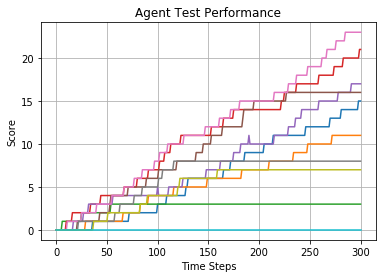

In [5]:
# Plot agent performance across several episodes
fig, ax = plt.subplots()
ax.grid()
ax.set_xlabel('Time Steps')
ax.set_ylabel('Score')
ax.set_title('Agent Test Performance')
ax.grid(1)
    
n_episodes = 10 
for i in range(n_episodes):
    # Create agent
    agent = Agent(state_size=37, action_size=4, seed=0, soft=True, 
              doubleDQN=True, duel=True, prioritized=True,
              alpha=0.6, beta_start=0.4, beta_end=1, beta_episodes=200,
              hidden_layers=[128,64], learn_rate=5e-4/2)

    # load the weights from file
    agent.qnet_local.load_state_dict(torch.load('checkpoint.pth'))

    env_info = env.reset(train_mode=True,)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0
    #t = 0
    score_t = [score]  # log score 
    for j in range(10000):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        state = env_info.vector_observations[0]        # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward
        #print("t: {}\taction:{}\treward: {}\tscore: {}\tdone: {}".format(t,action,reward,score,done))
        score_t.append(score) # log score 
        #t += 1
        if done:
            print("Episode {}\tScore: {}".format(i+1, score))
            break 

    # Plot score
    ax.plot(score_t)

**Figure 4**: Testing performance of the trained agent across 10 episodes. Scores shows some variance in the environment.

We know from the training results the agent can to solve the environment with an average above 13 points over 100 episodes, each consisting of 300 timesteps. During testing, we see the agent often scores above 13 points. We also notice significant variability in the environment, resulting in some high and low scores. In watching the agent perform, I noticed it can sometimes get "stuck" near a blue banana. It knows to avoid the blue banana, and ends up oscillates between actions to "wiggle" out of the situation. Bouncing back and forth between actions expends the allotted 300 time steps without accumulating as many yellow bananas, leading to the infrequent low score. 

In [6]:
#env.close()  # close Unity environment

## Learning Performance Comparison

---

I was curious to know how the different improvements to DQN impact learning performance for this environment. My approach was to generate learning curves across multiple (8) random seeds for five agent configurations:

* DQN
* Double DQN
* Double DQN with dueling architecture
* Double DQN with prioritized experience replay
* Double DQN with prioritized experience replay and dueling architecture 

A fair comparison should use a common environment random seed, especially due to the variance in environmental conditions observed in the agent performance plot across several episodes. In theory, by closing and re-instantiating the Unity environment, we can reset the environment random seed. However, an apparent bug throws an error and prevents re-instantiation of the Unity environment. Restarting the kernel is the only option to restart the Unity environment with a defined seed. However, I couldn't find a way to restart the kernel programmatically in Jupyter notebook. 

As a workaround, I use a bash shell script to manage each training run with a call to the Python script `train.py`. The shell script passes in command line arguments to specify the agent seed and configuration, and starts a new Unity environment instantiation with a defined seed each time. This approach ensures the environment seed is the same for every training run. To run the shell script, enter this command at the terminal:

```bash
./run_script.sh
```

The training results across five agent configurations and eight random seeds took about six hours to run on a p2.xlarge instance with GPUs on Amazon Web Services (AWS). The training results were logged and saved in the folder `results_aws`. Let's load those results and visualize agent learning.

In [7]:
import pandas as pd
import pickle
import os
from utils import *

# Define config labels
config_labels = ['DQN','DoubleDQN','DoubleDQN Dueling',
                'DoubleDQN PER','DoubleDQN Dueling PER']

# Result filename prefix identifies agent configuration
file_prefix = [0]*5
file_prefix[0] = 'doubleFalse_duelFalse_perFalse' # DQN
file_prefix[1] = 'doubleTrue_duelFalse_perFalse' # DobuleDQN
file_prefix[2] = 'doubleTrue_duelTrue_perFalse' # DoubleDQN Dueling
file_prefix[3] = 'doubleTrue_duelFalse_perTrue' # DoubleDQN PER
file_prefix[4] = 'doubleTrue_duelTrue_perTrue' # DoubleDQN Dueling PER

def get_results(results_dir, file_prefix):
    """Load saved results for training runs
    
    # Parameters
        results_dir (str): folder with results
        file_prefix (list of strs): prefix in filename
            identifying the agent configuration.
            
    # Returns
        List of dataframes for each agent configuration. 
        Each dataframe contains training results across random seeds.   
    """

    # Get filenames for results
    filenames = os.listdir(results_dir) # list of all log files
    filenames = [i for i in filenames if i != '.DS_Store'] # remove ".DS_Store"

    # Make list of dataframes, each containing all runs for one config
    n_configs = 5
    n_runs = int(len(filenames)/n_configs)
    results = []
    for c in range(n_configs):
        logs_config = []
        x = file_prefix[c] # prefix for this config
        files = [i for i in filenames if i[0:len(x)]==x] # files with this config prefix
        for f in files:
            filepath = results_dir + f
            logs_config.append(load_pkl(filepath, verbose=0))

        # Put logs from runs for a config into dataframe
        df = pd.DataFrame()
        for i in range(n_runs):
            # Turn the dict value from single run into dataframe col
            df[i] = list(logs_config[i].values())[0]

        col_names = ['run1', 'run2', 'run3', 'run4', 
                     'run5', 'run6', 'run7', 'run8']
        df.columns = col_names[0:n_runs]

        # Assemble list of dataframes for each config
        results.append(df)
    
    return results

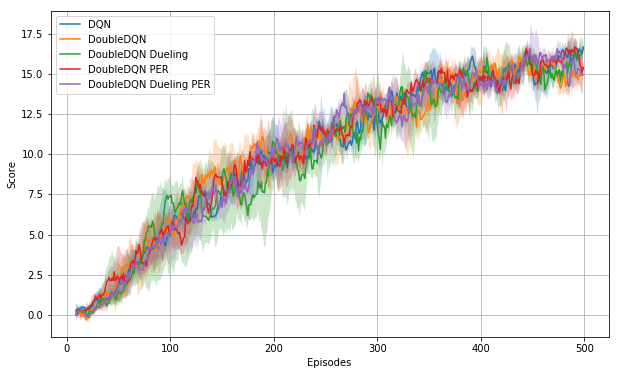

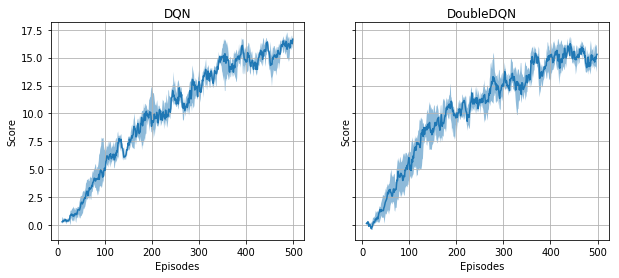

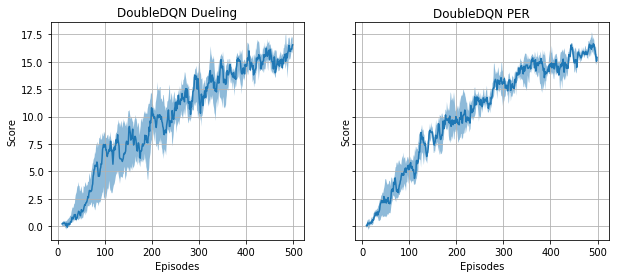

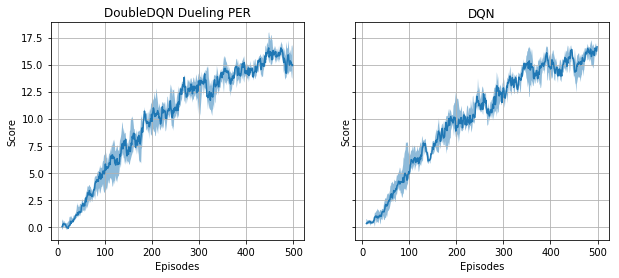

In [8]:
# Load and process results
results_dir = 'results_aws/'
results = get_results(results_dir, file_prefix)

# Plot learning curves for all configurations 
plot_overlaid(results, config_labels, [0,1,2,3,4], alpha=0.25, window=10)

# Plot side by side comparisons
plot_side_by_side(results, config_labels, [0,1], window=10)
plot_side_by_side(results, config_labels, [2,3], window=10)
plot_side_by_side(results, config_labels, [4,0], window=10)

**Figure 5**: Learning curves for five agent configurations. Solid line and shaded region correspond to the median and interquartile range across eight random seeds. In general, double DQN, dueling architecture, and prioritized replay do not improve learning significantly in the Banana Collectors environment. Dueling architecture appears to introduce more variance across seeds. 

Here we plot score across training episodes to visualize learning. To smooth the curves for readability, a moving average is taken across 10 episodes. Surprisingly, we don't see significant difference between the different agent configurations.

Regular DQN performs comparably to adding all the bells and whistles of double DQN, prioritized replay, and dueling architecture. Dueling architecture appears to introduce more variance across random seeds, which gets improved by adding prioritized replay. The improvement with prioritized replay may be due to the reduced learning rate. 

## Test another environment: Lunar Lander

---

The similarity in results across agent configuration were surprising, so I was curious to try training the same agent in a different environment. I ran the same study for the five agent configurations across five (rather than eight) random seeds in the Lunar Lander environment in OpenAI Gym. The only difference is the agent has three hidden layers of 256, 128, and 64 units compared to two hidden layers of 128 and 64 units. The extra first hidden layer of 256 units was found from prior experience to improve learning in Lunar Lander but not for Banana Collectors.

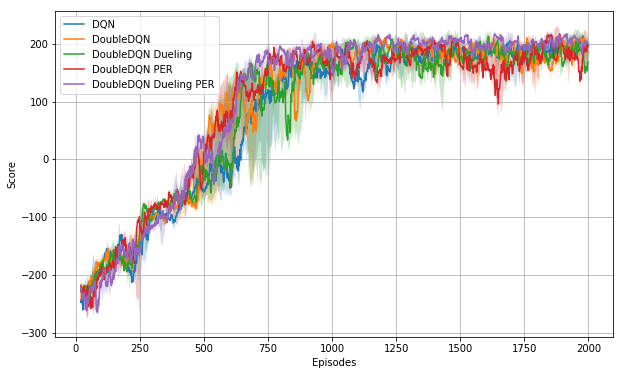

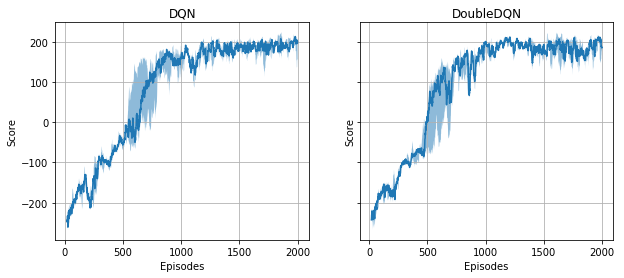

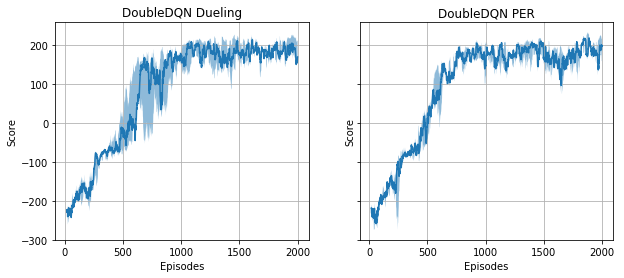

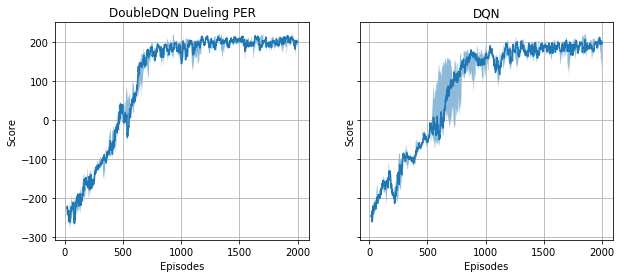

In [9]:
# Lunar Lander
# Load and process results
results_dir = 'results_lunarlander/'
results = get_results(results_dir, file_prefix)

# Plot learning curves for all configurations 
plot_overlaid(results, config_labels, [0,1,2,3,4], alpha=0.25, window=20)

# Plot side by side comparisons
plot_side_by_side(results, config_labels, [0,1], window=20)
plot_side_by_side(results, config_labels, [2,3], window=20)
plot_side_by_side(results, config_labels, [4,0], window=20)

**Figure 6**: Learning curves for five agent configurations in the Lunar Lander environment. Solid line and shaded region correspond to the median and interquartile range across five random seeds. Double DQN speeds up learning. Dueling architecture shows only marginal improves over double DQN and introduces more variance across seeds. Prioritized replay improves upon double DQN and dueling architecture by making learning more stable with less variance across random seed.

Using the same agent and running the same study on the Lunar Lander environment shows that improvements on DQN can indeed make a different. Double DQN speeds up learning. Dueling architecture seems to add variance across random seeds, but pairing with prioritized replay greatly reduces variance — perhaps due to the reduction in learning rate. Overall, using double DQN with dueling architecture and prioritized replay significantly improves learning over regular DQN for the Lunar Lander environment.

## Conclusions & Further Possibilities

---

We were able to train a reinforcement learning agent using deep Q-networks to solve the Banana Collectors Unity Environment. Surprisingly, comparing the learning performance across eight random seeds using DQN improvements such as Double DQN, dueling networks, and prioritized experience replay showed negligible benefit in this environment. In contrast, performing the same study in the Lunar Lander environment demonstrated learning improvements. I look forward to more thought about why that is. 

Many further possiblities exist for helping the agents learn better. Increasing size of the replay buffer will expanding the agent's memory capacity and can improve learning. The schedule for linearly annealing the bias correction in prioritized replay can be refined. We can adjust the frequency we update the fixed Q-target network weights and whether we use gradual soft updates or replace them in hard updates. We can implement the rank variant of prioritized replay rather than the current proportional variant. Further experimentation with other hyperparameters also can be explored.

## References

---

1. Mnih, Volodymyr, Kavukcuoglu, Koray, Silver, David, Rusu, Andrei A., Veness, Joel, Bellemare, Marc G., Graves, Alex, Riedmiller, Martin, Fidjeland, Andreas K., Ostrovski, Georg, Petersen, Stig, Beattie, Charles, Sadik, Amir, Antonoglou, Ioannis, King, Helen, Kumaran, Dharshan, Wierstra, Daan, Legg, Shane, and Hassabis, Demis. Human-level control through deep reinforcement learning. Nature, 518(7540):529–533, 02 2015. URL http://dx.doi.org/10.1038/nature14236.

2. Sutton, R. and Barto, A. Reinforcement Learning: An Introduction. MIT Press. 1998.

3. Thrun, S. and Schwartz, A. Issues in using function approxima- tion for reinforcement learning. In M. Mozer, P. Smolensky, D. Touretzky, J. Elman, and A. Weigend, editors, Proceedings of the 1993 Connectionist Models Summer School, Hillsdale, NJ, 1993. Lawrence Erlbaum.

4. Van Hasselt, Hado, Guez, Arthur, and Silver, David. Deep Reinforcement Learning with Double Q-learning. In Proceedings of the Thirtieth AAAI Conference on Artificial Intelligence, 2016. URL http://arxiv.org/abs/1509.06461.

5. Schaul, Tom, Quan, John, Antonoglou, Ioannis, and Silver, David. Prioritized experience replay. arXiv preprint arXiv:1511.05952, 2015.

6. https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/

7. Wang, Z., de Freitas, N., and Lanctot, M. Dueling Network Architectures for Deep Reinforcement Learning. ArXiv e-prints, November 2015.

8. https://github.com/jaara/AI-blog/blob/master/SumTree.py